# Potato Disease Classification

### Import all the Dependencies

In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

### Set all the Constants

In [5]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 128
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "merged_dataset"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE


## Initializing, Exploring & Partioning the Dataset

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


### Reading and Partitioning the Dataset
We create a Tensorflow Dataset Object and directly read it from the directory using `image_dataset_from_directory` and then split it using the function we created above

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 33562 files belonging to 55 classes.


### Checking the Available Classes

In [8]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

55 ['Apple__healthy', 'Apple__rust', 'Chili__healthy', 'Chili__leaf spot', 'Chili__whitefly', 'Coffee__cercospora_leaf_spot', 'Coffee__healthy', 'Coffee__red_spider_mite', 'Corn__common_rust', 'Corn__healthy', 'Corn__northern_leaf_blight', 'Cucumber__diseased', 'Cucumber__healthy', 'Gauva__diseased', 'Gauva__healthy', 'Grape__black_measles', 'Grape__black_rot', 'Grape__healthy', 'Grape__leaf_blight_(isariopsis_leaf_spot)', 'Jamun__diseased', 'Jamun__healthy', 'Lemon__diseased', 'Lemon__healthy', 'Mango__diseased', 'Mango__healthy', 'Pepper_bell__bacterial_spot', 'Pepper_bell__healthy', 'Pomegranate__diseased', 'Pomegranate__healthy', 'Potato__early_blight', 'Potato__healthy', 'Potato__late_blight', 'Rice__brown_spot', 'Rice__healthy', 'Rice__leaf_blast', 'Soybean__bacterial_blight', 'Soybean__caterpillar', 'Soybean__downy_mildew', 'Soybean__healthy', 'Soybean__rust', 'Soybean__southern_blight', 'Strawberry___leaf_scorch', 'Strawberry__healthy', 'Sugarcane__healthy', 'Sugarcane__rust', 

### Displaying Some Sample Images

In [13]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

### Checking Batch Size

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 128, 128, 3)
(32,)


### Cache, Shuffle, and Prefetch the Dataset

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


#### Checking what is the expected dimension order for channel

In [12]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [13]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2), padding='SAME'),  # Change padding to 'SAME'
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2), padding='SAME'),  # Change padding to 'SAME'
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2), padding='SAME'),  # Change padding to 'SAME'
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [21]:
# model = models.Sequential([
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),   
# ])
# model.build(input_shape=batch_input_shape)

### Model Summary

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 63, 63, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 31, 31, 64)          0         
 g2D)                                                 

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training the Network

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)


Epoch 1/50
839/839 [==============================] - 517s 278ms/step - loss: 1.9188 - accuracy: 0.4686 - val_loss: 1.3668 - val_accuracy: 0.5712
Epoch 2/50
839/839 [==============================] - 169s 202ms/step - loss: 1.0857 - accuracy: 0.6599 - val_loss: 0.9649 - val_accuracy: 0.7004
Epoch 3/50
839/839 [==============================] - 168s 200ms/step - loss: 0.8494 - accuracy: 0.7298 - val_loss: 0.7443 - val_accuracy: 0.7542
Epoch 4/50
839/839 [==============================] - 168s 201ms/step - loss: 0.7313 - accuracy: 0.7631 - val_loss: 0.7679 - val_accuracy: 0.7578
Epoch 5/50
839/839 [==============================] - 168s 201ms/step - loss: 0.6623 - accuracy: 0.7843 - val_loss: 0.5998 - val_accuracy: 0.8005
Epoch 6/50
839/839 [==============================] - 171s 204ms/step - loss: 0.5840 - accuracy: 0.8082 - val_loss: 0.6005 - val_accuracy: 0.7882
Epoch 7/50
839/839 [==============================] - 171s 204ms/step - loss: 0.5498 - accuracy: 0.8169 - val_loss: 0.5990 -

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
839/839 [==============================] - 167s 199ms/step - loss: 0.4263 - accuracy: 0.8531 - val_loss: 0.4168 - val_accuracy: 0.8543
Epoch 2/10
839/839 [==============================] - 170s 203ms/step - loss: 0.4151 - accuracy: 0.8568 - val_loss: 0.4669 - val_accuracy: 0.8389
Epoch 3/10
839/839 [==============================] - 170s 203ms/step - loss: 0.3874 - accuracy: 0.8665 - val_loss: 0.4792 - val_accuracy: 0.8326
Epoch 4/10
839/839 [==============================] - 170s 203ms/step - loss: 0.3857 - accuracy: 0.8657 - val_loss: 0.4020 - val_accuracy: 0.8591
Epoch 5/10
839/839 [==============================] - 168s 200ms/step - loss: 0.3703 - accuracy: 0.8704 - val_loss: 0.4365 - val_accuracy: 0.8513
Epoch 6/10
839/839 [==============================] - 163s 195ms/step - loss: 0.3723 - accuracy: 0.8720 - val_loss: 0.4158 - val_accuracy: 0.8603
Epoch 7/10
839/839 [==============================] - 166s 198ms/step - loss: 0.3597 - accuracy: 0.8755 - val_loss: 0.4288 -

### Testing the Model

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy


106/106 [==============================] - 74s 41ms/step - loss: 0.2136 - accuracy: 0.9260
Test Accuracy: 92.60000000000001%


### Plotting the Accuracy and Loss Curves

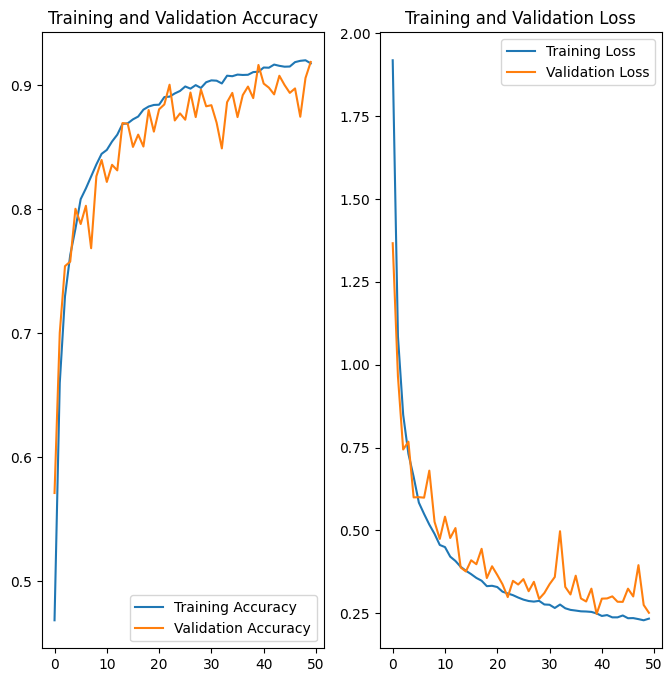

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Saving the Model
We append the model to the list of models as a new version

In [20]:
import os
model_version = max([int(i) for i in (os.listdir("../models")+[0])]) + 1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'

### Function for Inference

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Plotting the Inference Data

In [ ]:
def plot_confusion_matrix(actual_class, predicted_class, labels, ds_type):
  cm = tf.math.confusion_matrix(actual_class, predicted_class)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

1/1 [==============================] - 0s 17ms/step


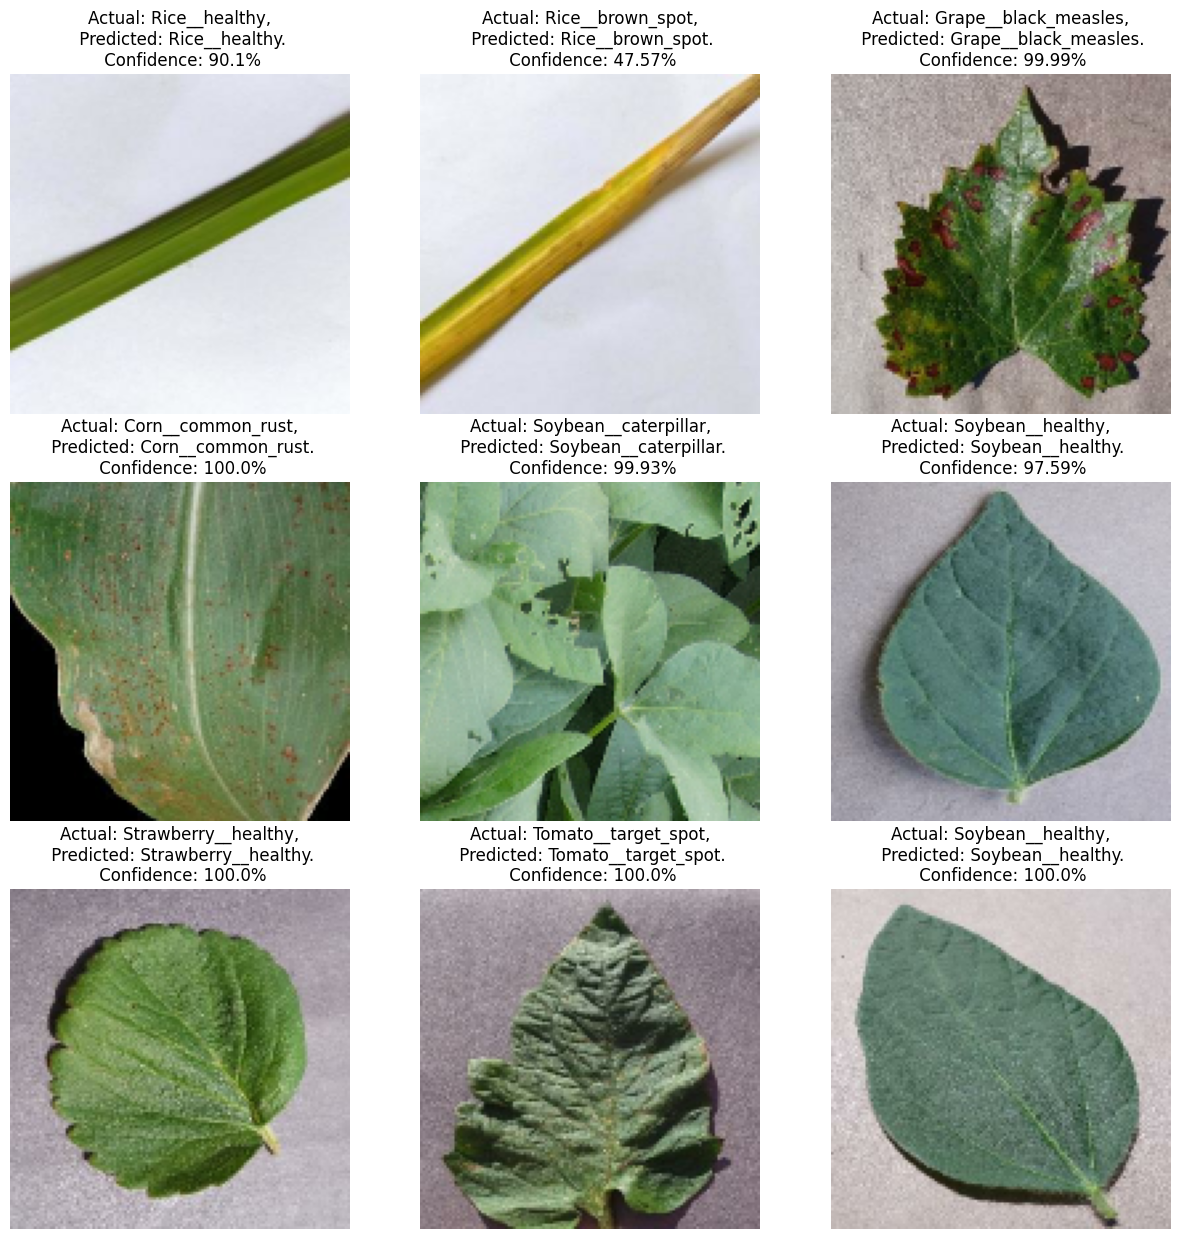

In [22]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [26]:
def plot_confusion_matrix(actual_class, predicted_class, labels, ds_type):
  cm = tf.math.confusion_matrix(actual_class, predicted_class)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [28]:
!pip install frame-generator

In [32]:
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform actual and predicted class labels
actual_class_encoded = label_encoder.fit_transform(actual_class)
predicted_class_encoded = label_encoder.transform(predicted_class)

# Now you can use the encoded labels to compute the confusion matrix
cm = tf.math.confusion_matrix(actual_class_encoded, predicted_class_encoded)


ValueError: y should be a 1d array, got an array of shape () instead.

In [23]:
!pip install h5py

In [24]:
model_json=model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [25]:
print("Model saved to disk")

Model saved to disk
